In [50]:
# import standard libraries
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text 
from sklearn.model_selection import train_test_split

# File links in markdown cells
from IPython.display import FileLink, FileLinks

#robotmagic which does not work
from mytools import robot

# keras and tensorflow for deep learning would have been cool, but ran out of disk space.

# pickle for serialization
import pickle

# do we use the MLPClassifier?
from sklearn.neural_network import MLPClassifier

# nltk stemming
import nltk
from nltk.stem import PorterStemmer

# cld2-cffi for text language identification, only works if you can install gcc, which requires SUDO ACCESS
# import cld2
from langdetect import detect

# nltk sentiment analysis
#nltk.download('vader_lexicon')
#from nltk.sentiment import SentimentIntensityAnalyzer

# wordcloud for beautiful wordclouds in notebooks
from wordcloud import WordCloud

#SQLite database
import sqlite3

#disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [51]:
# define our classification target
classification_target_column = 'title'

# our mapping to detect language of content
# cld2 is NOT USABLE IN LECTURE SINCE WE HAVE NO GCC. See Alternative
def detect_language_from_content(contentstring):
    isReliable, textBytesFound, details = cld2.detect(contentstring)
    if details:
        return details[0].language_name if details else 'Unknown'
    
# we use langdetect as alternative.
def detect_language_from_content_alternative(contentstring):
    lang = 'Unknown'
    
    try:
        lang = detect(contentstring)
    except:
        pass
    return 'ENGLISH' if lang == 'en' else 'Unknown'

# define stemming for texts
ps = PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split(" ")])

# 1. Fetching Reviews from Amazon about products. Using the Robot Framework

The [config.resource](./config.resource) contains any global variables concerning the robot

Since the notebook cell magic doesnt work right, <br>
we manually execute the command to execute the t6 robot

In [3]:
! python -m robot t6.robot

T6                                                                            
Fetch All Reviews                                                     Search results page is https://www.amazon.com/s?k=4k+monitor&language=en_US
Now Sleeping
Loop Through products
Product: SAMSUNG 34-Inch SJ55W Ultrawide Gaming Monitor (LS34J550WQNXZA) – 75Hz Refresh, WQHD Computer Monitor, 3440 x 1440p Resolution, 4ms Response, FreeSync, Split Screen, HDMI, Black
Product link: https://www.amazon.com/gp/slredirect/picassoRedirect.html/ref=pa_sp_atf_aps_sr_pg1_1?ie=UTF8&adId=A09023893BFAYOOAZ6IR5&url=%2FSamsung-S34J55W-34-Inch-Ultrawide-LS34J550WQNXZA%2Fdp%2FB07FBS36W2%2Fref%3Dsr_1_1_sspa%3Fkeywords%3D4k%2Bmonitor%26qid%3D1656014458%26sr%3D8-1-spons%26psc%3D1&qualifier=1656014458&id=5974824506180589&widgetName=sp_atf
Could not fetch reviews from this one :(
Product: Sceptre 27-Inch FHD LED Gaming Monitor 75Hz 2X HDMI VGA Build-in Speakers, Ultra Slim Metal Black
Product link: https://www.amazon.com/gp/slredi

# 2. Preprocessing
assuming we have fetched all the Amazon Reviews now into a csv file.
We want to read in the csv file and later train a machine on it.
The csv file contains ratings, titles and review contents in text format.

But we have to preprocess it. <br>
Extracting it for english language, conquer imbalance and so forth

In [52]:
# read in the csv and print shape of how much data we have
df = pd.read_csv('./output/amazon_reviews_4k_monitor_25.csv', encoding = 'utf-8', usecols=['rating', 'title', 'content'])
print(df.shape)

(6659, 3)


In [53]:
# look at first few and last few elements if any major issues are present.
df.iloc[4:-4, :]

rating                                              title  \
4          5  This Samsung ultra wide QHD monitor has the 3 ...   
5          5                   Don't get caught up in the curve   
6          4                       Great Features, Okay Picture   
7          5  I have been waiting for a monitor like this fo...   
8          5                       A wide window to the furture   
...      ...                                                ...   
6650       1                                          sent back   
6651       1                          Don't buy dim only 1 hdmi   
6652       1                     worst monitor I've ever bought   
6653       5                                   4K 60hz niceness   
6654       1  Screen is too dark, even with 100% brightness/...   

                                                content  
4     The 34" Samsung SJ55W Ultra WQHD Monitor will ...  
5     I put off purchasing this for a month because ...  
6     + PBP/PIP is amazing. If you're buying this mo...  
7     I am thrilled with the quality and detail of t...  
8     2019 is a year that brings the future into rea...  
...                                                 ...  
6650  sent back decided was not what I wanted,got my...  
6651  This is product sucks its dim and the stand is...  
6652  The picture quality is bad, there isn't an opt...  
6653  Plug and play from the included cables. Was ea...  
6654  I love the size/look of this monitor but when ...  

[6651 rows x 3 columns]

### Kick NA values

In [54]:
# kick some rows that contain null values
df.dropna(how='any', inplace=True, subset = ['rating', 'content', 'title'])
print(df.shape)

(6645, 3)


### Fix data types

In [55]:
df.loc[:, 'title'] = df.loc[:, 'title'].astype('string', copy=False, errors='raise')
df.loc[:, 'content'] = df.loc[:, 'content'].astype('string', copy=False, errors='raise')
print(df.dtypes)

rating      int64
title      string
content    string
dtype: object


### English Language

In [56]:
# detect languages and kick non-english ones

# This method doesnt work on the uni machines since we cannot install df2
#df['detectedContentLanguage'] = df['content'].apply(detect_language_from_content)
#df = df[df['detectedContentLanguage'] == 'ENGLISH']

# Alternative, langdetect
df['detectedContentLanguage'] = df['content'].apply(detect_language_from_content_alternative)
df = df[df['detectedContentLanguage'] == 'ENGLISH']

print(df.shape)

(6401, 4)


### Lowercase and Punctuation

In [57]:
# store original content and title in their own columns
df['original_content'] = df['content']
df['original_title'] = df['title']

# make lowercase and remove punctuation
allowedWords = '[^a-z A-Z 0-9-]+'
df['content'] = df['content'].str.lower().apply(lambda x: re.sub(allowedWords, '', x))
df['title'] = df['title'].str.lower().apply(lambda x: re.sub(allowedWords, '', x))

### Re-Index

In [58]:
# check if the datatypes are what we aim for (rating should be number, text of type string obviously)
df.reset_index(inplace=True)
print(df.shape)
print(df.info())
display(df)

(6401, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6401 entries, 0 to 6400
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    6401 non-null   int64 
 1   rating                   6401 non-null   int64 
 2   title                    6401 non-null   object
 3   content                  6401 non-null   object
 4   detectedContentLanguage  6401 non-null   object
 5   original_content         6401 non-null   string
 6   original_title           6401 non-null   string
dtypes: int64(2), object(3), string(2)
memory usage: 350.2+ KB
None


index  rating                                              title  \
0         0       5                    perfect monitor for a developer   
1         1       5  macbook pro with 34 samsung curved monitor wit...   
2         2       4  samsung skimped out and thats why its only 4 s...   
3         3       5                                  excellent monitor   
4         4       5  this samsung ultra wide qhd monitor has the 3 ...   
...     ...     ...                                                ...   
6396   6654       1  screen is too dark even with 100 brightnesscon...   
6397   6655       1                         keep getting used monitors   
6398   6656       5  the samsung s27a700nwn monitor that bought is ...   
6399   6657       4                                 good for its price   
6400   6658       5          matched to an apple mac mini for home use   

                                                content  \
0     i can finally say that ive found a monitor tha...   
1     ok im 45 and a programmer and im telling you i...   
2     i get it im buying literally the cheapest ultr...   
3     so far i am enjoying my new samsung ultra wide...   
4     the 34 samsung sj55w ultra wqhd monitor will b...   
...                                                 ...   
6396  i love the sizelook of this monitor but when v...   
6397  order this and the first monitor arrived repac...   
6398  clearly amazon is once again combining reviews...   
6399  this monitor is quite decent for its price com...   
6400  very happy with the quality and the ease of co...   

     detectedContentLanguage  \
0                    ENGLISH   
1                    ENGLISH   
2                    ENGLISH   
3                    ENGLISH   
4                    ENGLISH   
...                      ...   
6396                 ENGLISH   
6397                 ENGLISH   
6398                 ENGLISH   
6399                 ENGLISH   
6400                 ENGLISH   

                                       original_content  \
0     I can finally say that I’ve found a monitor th...   
1     Ok, I'm 45 and a programmer and I'm telling yo...   
2     I get it, I'm buying literally the cheapest ul...   
3     So far, I am enjoying my new Samsung Ultra Wid...   
4     The 34" Samsung SJ55W Ultra WQHD Monitor will ...   
...                                                 ...   
6396  I love the size/look of this monitor but when ...   
6397  Order this and the first monitor arrived repac...   
6398  Clearly Amazon is once again combining reviews...   
6399  This monitor is quite decent for its price. Co...   
6400  Very happy with the quality and the ease of co...   

                                         original_title  
0                       Perfect monitor for a developer  
1     Macbook Pro with 34" Samsung Curved Monitor wi...  
2     Samsung skimped out and thats why its only 4 s...  
3                                     Excellent Monitor  
4     This Samsung ultra wide QHD monitor has the 3 ...  
...                                                 ...  
6396  Screen is too dark, even with 100% brightness/...  
6397                         Keep getting used monitors  
6398  The Samsung S27A700NWN monitor that bought is ...  
6399                                 Good for its price  
6400          Matched to an Apple Mac mini for home use  

[6401 rows x 7 columns]

### Lemmatization Or Stemming

Typically, the Lemmatization & Stemming would give us the raw words of declinated versions. <br>
But here we look into an example where the effect is not the desired one. <br>
it gives us a result with which we are not satisfied. So we won't do stemming on our review texts.

In [59]:
print(df["title"][6])
df["reviewTitle"] = df[classification_target_column].apply(lambda text: stem_words(text))
print('...stemmed...')
print(df["reviewTitle"][6])

great features okay picture
...stemmed...
great featur okay pictur


### Text Length
One bigger problem is the largely varying text length of amazon reviews.
We could filter out titles that are way too long

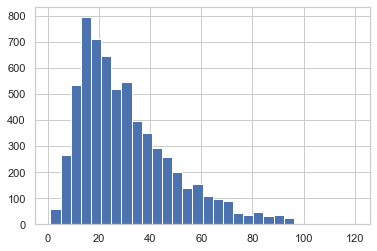

In [60]:
# copy a col for contentlength
df['content-length'] = [len(item) for item in df[classification_target_column]]

# Lowerbound length of what we accept. for titles 0, for reviews maybe 50 words = 250 characters on average. Assuming on average 5 characters per english word.
lowerbound = 250 if classification_target_column == 'content' else 0
# Upperbound: for titles 30 words (=150). for content more like 4000.
upperbound = 4000 if classification_target_column == 'content' else 150

df = df[df['content-length'] > lowerbound]
df = df[df['content-length'] < upperbound]
plt.figure()
df_hist = plt.hist(df['content-length'], bins=30)
plt.show()

### Conquer Rating Imbalance

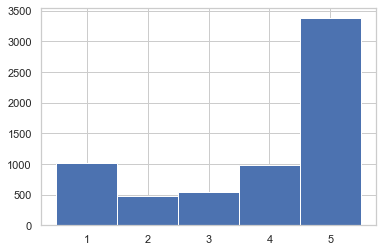

 min number of observations: 472


In [61]:
# look at the distribution of ratings
plt.figure()
df_hist = plt.hist(df['rating'], bins=np.arange(1, 7)-0.5)
plt.show()

minobs = min(df['rating'].value_counts())
print(' min number of observations:', minobs)

In [62]:
# sample over our minimum and shuffle again
df = df.groupby('rating').sample(n=minobs)
df = df.sample(frac=1).reset_index(drop=True)
df.reset_index(inplace=True)
print(df['rating'].value_counts())

1    472
4    472
5    472
3    472
2    472
Name: rating, dtype: int64


### Vectorize Words

In [63]:
# create a vectorizer
# we already did lowercase, but doesnt hurt if the vectorizer does it again by default

#vctr = TfidfVectorizer(
vctr = CountVectorizer(
    max_features=150, 
    #ngram_range=(1,2),
    stop_words=text.ENGLISH_STOP_WORDS,
    token_pattern=r'\b[a-zA-Z0-9]{3,}\b'
    )

# create the transformed vectors
word_count_vector = vctr.fit_transform(df[classification_target_column]);
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True) 
# and create the tfidf weights based on the Tfidf scoring
tf_idf_vector = tfidf_transformer.fit_transform(word_count_vector)

In [64]:
# for quick inspection, create a dataframe of the word "weights" and show
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vctr.get_feature_names_out(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'], ascending=False)

idf_weights
60hz        6.281934
big         6.281934
wow         6.281934
worst       6.281934
wont        6.281934
...              ...
screen      3.899306
quality     3.811013
good        3.373213
great       2.970783
monitor     2.424719

[150 rows x 1 columns]

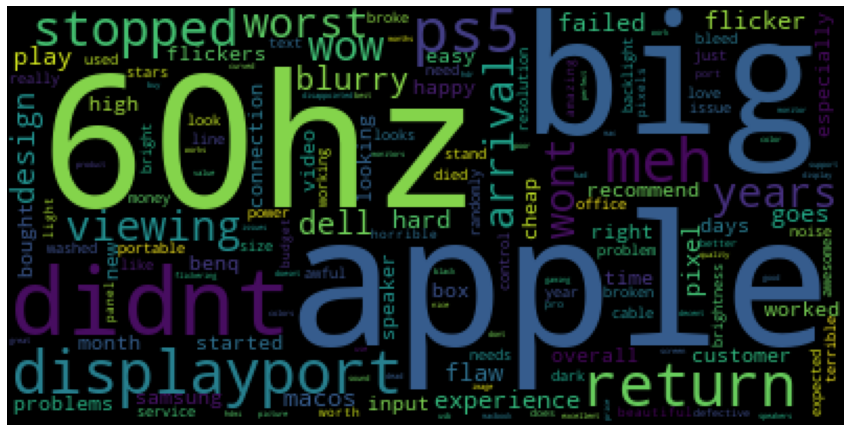

In [65]:
# Make a wordcloud of the most frequent words, because its beautiful
wordcloud = WordCloud().generate_from_frequencies(df_idf['idf_weights'])

#recolor and adjust size
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 3. Model Training and Evaluation on Training/Test Data

### Prepare Data & Split Training / Test

In [66]:
# the ratings are our labels, the word vectors are our observations
# Interestingly, the CountVectorizer itself seems to perform better than the TfIdf transformer.
X = vctr.fit_transform(df[classification_target_column]) #tf_idf_vector
Y = np.array([ x  for x in df['rating'] ])

In [67]:
# split training test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print('training / test size:', X_train.shape[0], ' to ', X_test.shape[0])

training / test size: 1888  to  472


### MLP Classifier

In [68]:
clf = MLPClassifier(random_state=1, max_iter=40).fit(X_train, y_train)

print('score train:', clf.score(X_train, y_train))
print('score test: ', clf.score(X_test, y_test))

score train: 0.6366525423728814
score test:  0.4385593220338983


In [69]:
# lets print of an arbitrary test observation the values.
# what do we predict, what is it actually and the title
test_target = 26
print(clf.predict(X_test[test_target]), y_test[test_target], df['title'][test_target])

[3] 3 not worth the price


# 4. Serialization of Our Data & Model

### Serialize the Model

In [70]:
# we save the model with some meta info.
fullpackage = {'info': 'my cool trained model.', 'classifier': clf, 'text-length-upperbound': upperbound, 'vectorizer': vctr}
print(fullpackage)

{'info': 'my cool trained model.', 'classifier': MLPClassifier(max_iter=40, random_state=1), 'text-length-upperbound': 150, 'vectorizer': CountVectorizer(max_features=150,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                token_pattern='\\b[a-zA-Z0-9]{3,}\\b')}


In [71]:
pickle.dump(fullpackage, open( "review_classifier_package.ml", "wb" ) )

### Save data to the database in addition

In [72]:
sqldf = df[['rating', 'original_title', 'original_content']]
sqldf.columns=['rating', 'title', 'content']
sqldf.head()

rating                                              title  \
0       1                            really dim in HDR model   
1       4              The screen DOES NOT reflect sunlight.   
2       5                       the best monitor that I have   
3       3  Disappointed Old Form Factor for the Price for...   
4       4  Superb and a good choice for gaming; not the b...   

                                             content  
0  Really loudly coil whining noise. And there ar...  
1  If your room is like mine where your desk is i...  
2  So far this is the best monitor that I bought ...  
3  I gave this low rating because the old format ...  
4  If you just want a 4K60 fps display that is br...

In [73]:
# copy original texts from old dataframe


# connect to local embedded database
database = "./db/amazon_reviews.sqlite"
conn = sqlite3.connect(database)

# drop table if exists
cur = conn.cursor()
cur.execute("drop table if exists Reviews")

# take only a part of the original df with original texts
sqldf = df[['rating', 'original_title', 'original_content']]
sqldf.columns=['rating', 'title', 'content']
sqldf.to_sql(name='Reviews', con=conn)
conn.close()

# 5. Interesting Reviews Examples

1. Some reviews seem quite contradicting. For example, the first one: Its star rating is consistent with its title. But its review content is not <br>
Whyever the person wrote such a review. But this shows that the users themselves are not always consistent with their ratings.

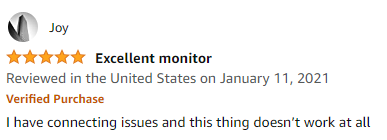

2. The second one has a title that basically says nothing. What is _Large Screen_ supposed to mean? But the content description is pretty accurate with the rating.<br>

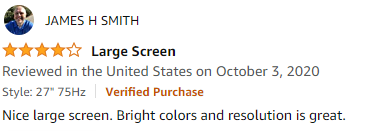

3. The third one just has a funny title

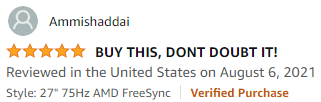

# 6. Frontend Website

The website is hosted at http://localhost:8080. <br>
You can start the website with the command below, in the end it is just the frontend.py one directory above. <br>
Once again this works different on windows than on linux.

In [32]:
%%bash
cd ..
python -m frontend

Couldn't find program: 'bash'


In [74]:
! jupyter nbconvert --to html IndividualProject.ipynb.

[NbConvertApp] Converting notebook IndividualProject.ipynb. to html
[NbConvertApp] Writing 1092655 bytes to IndividualProject.ipynb.html
